<a href="https://colab.research.google.com/github/aliabdari/compressed-QA/blob/main/QA_compressed_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [4]:
x_temp = np.load('/content/drive/MyDrive/information_live/x_vgg16.npy',allow_pickle= True)

In [5]:
x_temp.shape[0]

160

In [6]:
x_temp2 = np.empty(150,dtype=object)

In [7]:
idx = 0
for i in range(x_temp.shape[0]):
  if i % 16 == 0:
    continue
  x_temp2[idx] = x_temp[i]
  idx+=1

In [8]:
x_temp2.shape

(150,)

## Load DOM

In [9]:
y_temp = np.loadtxt('/content/drive/MyDrive/live_dataset_Reconstructed_Residuals/live_video_quality_data.txt')

In [10]:
y_temp.shape

(150, 2)

In [11]:
y = y_temp[:,0]

In [12]:
y = np.asarray(y).astype('float32')

In [13]:
max_y = np.max(y)

In [14]:
y=y/max_y

## POT

In [15]:
np.mean(x_temp2[10], axis=1).shape

(4096,)

In [16]:
x = np.empty((150,4096),dtype=object)
for i in range(x_temp2.shape[0]):
  x[i,:] = np.mean(x_temp2[i], axis=1)
  pass

In [17]:
x.shape

(150, 4096)

In [18]:
x = np.asarray(x).astype('float32')

In [19]:
np.max(x)

4.789821

In [20]:
x = x/np.max(x)

# Data preparation

In [21]:
x_test = x[0:30,:].copy()
y_test = y[0:30].copy()

In [22]:
x_test.shape

(30, 4096)

In [23]:
x_train = x[30:,:].copy()
y_train = y[30:].copy()

In [24]:
x_train.shape

(120, 4096)

In [25]:
def do_shuffle(X,Y,number_of_data):
  shuffle_index = np.arange(number_of_data)
  np.random.shuffle(shuffle_index)
  return X[shuffle_index],Y[shuffle_index]

In [26]:
x_train,y_train = do_shuffle(x_train,y_train,120)

In [27]:
x_train.dtype

dtype('float32')

## Model

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.08, shuffle= True)

In [29]:
model = Sequential()
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8,activation="linear"))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(4,activation="linear"))
model.add(Dense(1, activation="linear"))


callbacks = [
    keras.callbacks.ModelCheckpoint("QA_compressed.h5", save_best_only=True),
		keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

opt = Adam(learning_rate=1e-4 / 3, decay=1e-3 / 100)
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(x=x_train, y=y_train, 
	validation_data=(x_valid, y_valid),
	epochs=2000, 
	batch_size=64)

Epoch 1/2000
2/2 [==============================] - 5s 204ms/step - loss: 3.4209 - val_loss: 0.3505
Epoch 2/2000
2/2 [==============================] - 0s 24ms/step - loss: 2.6176 - val_loss: 0.3926
Epoch 3/2000
2/2 [==============================] - 0s 23ms/step - loss: 2.4890 - val_loss: 0.4309
Epoch 4/2000
2/2 [==============================] - 0s 23ms/step - loss: 2.9489 - val_loss: 0.4507
Epoch 5/2000
2/2 [==============================] - 0s 23ms/step - loss: 2.8790 - val_loss: 0.4662
Epoch 6/2000
2/2 [==============================] - 0s 41ms/step - loss: 2.7721 - val_loss: 0.4863
Epoch 7/2000
2/2 [==============================] - 0s 24ms/step - loss: 3.2778 - val_loss: 0.4989
Epoch 8/2000
2/2 [==============================] - 0s 23ms/step - loss: 2.4549 - val_loss: 0.5113
Epoch 9/2000
2/2 [==============================] - 0s 23ms/step - loss: 3.1221 - val_loss: 0.5097
Epoch 10/2000
2/2 [==============================] - 0s 28ms/step - loss: 2.1022 - val_loss: 0.5087
Epoch 11

## Plot

In [30]:
def plot_diagrams_trian_process(history):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])

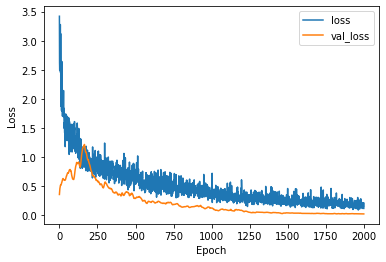

In [31]:
plot_diagrams_trian_process(history.history)

##Predict

In [32]:
y_test_predict = model.predict(x_test)
y_test_predict *= max_y

In [33]:
y_test_orig = y_test * max_y

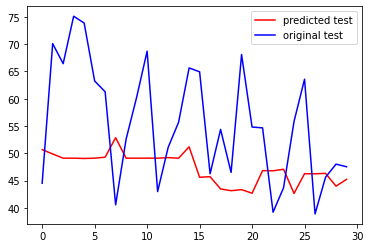

In [34]:
plt.plot(y_test_predict, label = 'predicted test' ,color = 'red')
plt.plot(y_test_orig, label = 'original test' ,color = 'blue')
plt.legend()

## Spearman and Pearson Correlation

Pearson correlation: Pearson correlation evaluates the linear relationship between two continuous variables.

Spearman correlation: Spearman correlation evaluates the monotonic relationship. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.

In [35]:
np.squeeze(y_test_predict, axis=1).shape

(30,)

In [36]:
np.corrcoef(y_test_orig, np.squeeze(y_test_predict, axis=1))

array([[1.        , 0.15268172],
       [0.15268172, 1.        ]])

In [37]:
from scipy import stats
rho, pval = stats.spearmanr(np.squeeze(y_test_predict, axis=1), y_test_orig)

In [38]:
rho

0.12329315541440174

In [42]:
from scipy.stats import pearsonr
pearsonr(y_test_orig, np.squeeze(y_test_predict, axis=1))

(0.15268171731196784, 0.4205446592927541)

## Train Data evaluation

In [39]:
y_train_predict = model.predict(x_train)
y_train_predict *= max_y
y_train_orig = y_train * max_y

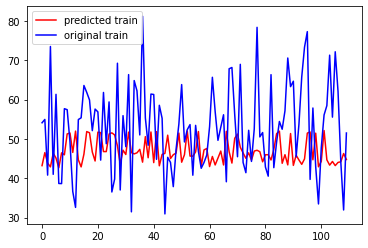

In [40]:
plt.plot(y_train_predict, label = 'predicted train' ,color = 'red')
plt.plot(y_train_orig, label = 'original train' ,color = 'blue')
plt.legend()